At start I have specified my tones in array which can be adjusted to as many tones to analyse as wished and imported all libraries needed for analysation.

In [43]:
# xgerge01
SELECTED_MIDI = [40, 65, 82]             # selected tones

In [44]:
import numpy as np                       # cupy for hardware acceleration
import matplotlib.pyplot as plt
import scipy.signal as ss
import soundfile as sf
from IPython.display import Audio
from IPython.display import display

**4.1 Basics (Základy)**

All tones were loaded from *klavir.wav* with example code and corresponding MIDI frequencies were loaded from *midi.txt*. My tones were saved as *a_orig.wav*, *b_orig.wav*, *c_orig.wav*. Sampling frequency of signals is $F_s=48000$ Hz.

To display 3 periods of my tone from loaded parts of signal, I have used their MIDI base frequencies ($F_M$) and calculated one period of signal ($T_1$).

$T_1=\frac{F_s}{F_M}$

Calculation with MIDI base frequency might not be the perfect, because it is not the exact base frequency of my tone, but it is close enough for this purpose.

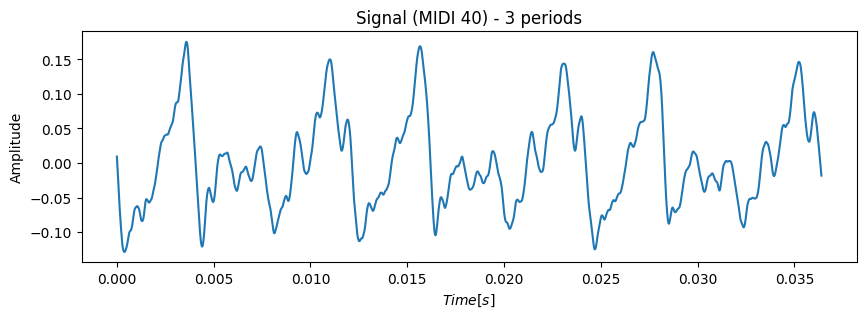

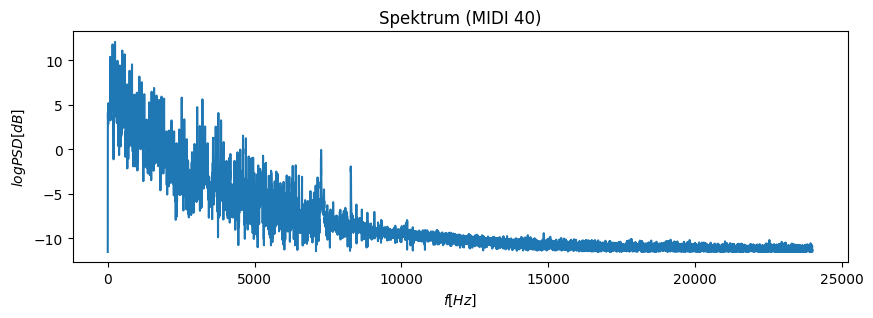

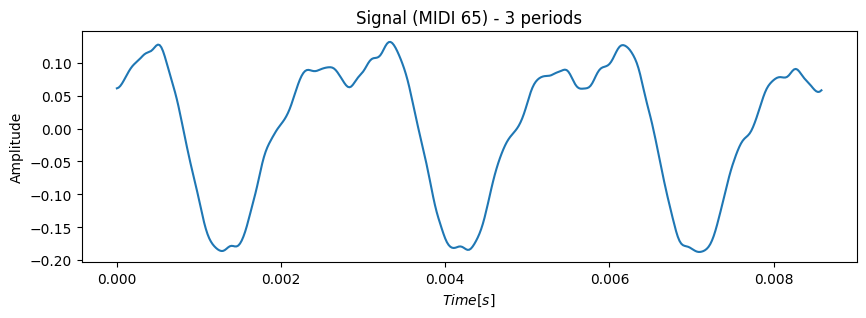

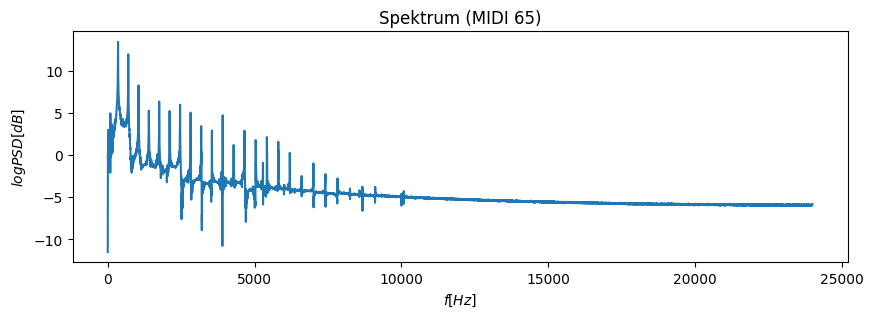

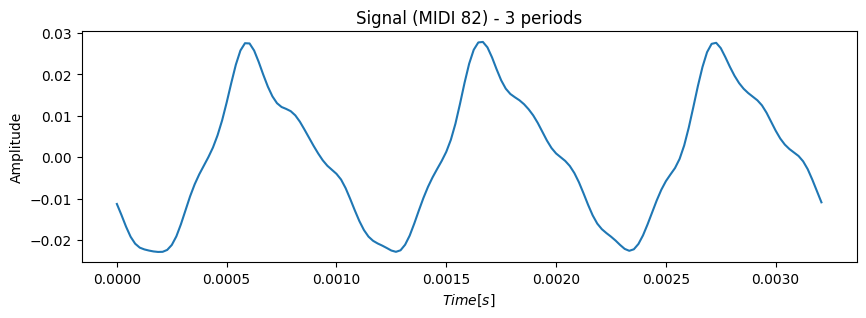

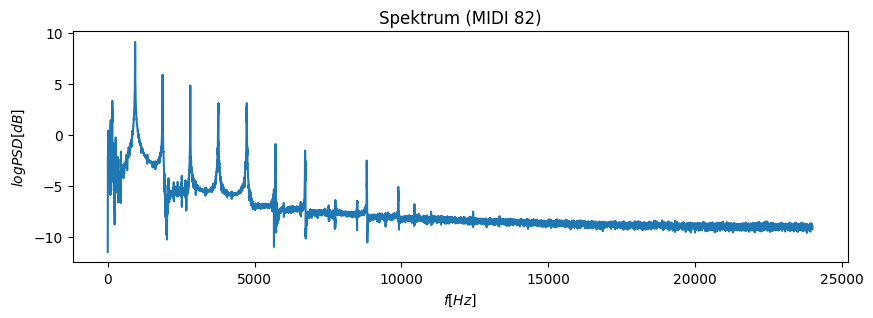

In [45]:
#  4.1 Basics (Základy)

MIDIFROM = 24
MIDITO = 108

SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2

# load midi (expected) base frequencies from file
file_data = np.loadtxt('midi.txt')
file_data = file_data[:,1][::-1]
midi_fmax_orig = np.zeros(MIDITO+1)
midi_fmax_orig[MIDIFROM:MIDITO+1] = file_data

# load sound file
howmanytones = MIDITO - MIDIFROM + 1    # tone count
tones = np.arange(MIDIFROM, MIDITO+1)   # 24-108

s, Fs = sf.read('../src/klavir.wav')        # read sound file

N = int(Fs * HOWMUCH_SEC)               # sample count for selected part of tone
Nwholetone = int(Fs * WHOLETONE_SEC)    # sample count for whole tone

xall = np.zeros((MIDITO+1, N))          # matrix (109 tones x 24000 samples) with all tones - first signals empty,
                                        # but we have plenty of memory ...
                             
samplefrom = int(SKIP_SEC * Fs)         # first tone to start from
sampleto = samplefrom + N               # first tone to end with

for tone in tones:
    x = s[samplefrom:sampleto]          # select part of tone
    x = x - np.mean(x)                  # safer to center ...
    xall[tone,:] = x                    # save tone to matrix

    samplefrom += Nwholetone            # next tone
    sampleto += Nwholetone              # next tone

PERIODS = 3

tone_name_start = 'a'                   # selected tones start name
for i in range(len(SELECTED_MIDI)):
    tone_name = chr(ord(tone_name_start) + i)

    # save orig tone
    #display(Audio(xall[SELECTED_MIDI[i]], rate=Fs))
    sf.write('../audio/%c_orig.wav' % tone_name, xall[SELECTED_MIDI[i]], Fs)

    # plot periods of tone
    tone_period = Fs / midi_fmax_orig[SELECTED_MIDI[i]]
    time_steps = np.arange(0,PERIODS*tone_period/Fs,step=1/Fs)
    plt.figure(figsize=(10, 3))
    plt.title('Signal (MIDI %d) - %d periods' % (SELECTED_MIDI[i], PERIODS))
    plt.plot(time_steps, xall[SELECTED_MIDI[i]][:time_steps.size])
    plt.ylabel('Amplitude')
    plt.xlabel('$Time[s]$')
    plt.show()

    # dft
    X = np.fft.fft(xall[SELECTED_MIDI[i]])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2 
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs 

    spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

    # plot analysis
    plt.figure(figsize=(10,3))
    plt.title('Spektrum (MIDI %d)' % SELECTED_MIDI[i])
    plt.plot(f, spect)
    plt.ylabel('$logPSD[dB]$')
    plt.xlabel('$f[Hz]$')
    plt.show()

**4.1 Fundamental frequency selection (Určení základní frekvence)**

To find the fundamental frequency of my tone, I have used DFT and selected the highest peak of the magnitude spectrum, which gives the fundamental frequency of my tone from DFT.

I have used also autocorrelation to find the fundamental frequency of my tones. I have applied filter for autocorrelation coefficients to find only the highest peaks. Filtered signal then could be used in function 'find_peaks' that returns all peaks except the first one which is at the beginning of the signal. Sampling frequency divided by the second peak gives the fundamental frequency of my tone from autocorrelation. 

As mentioned in project description, DFT has failed to find the fundamental frequency of my tone in *a_orig.wav* due to missing fundamental frequency in the tone. Found fundamental frequency was 3 times multiplied. I could compare the results with autocorrelation, where the found fundamental frequency was close to the real one.

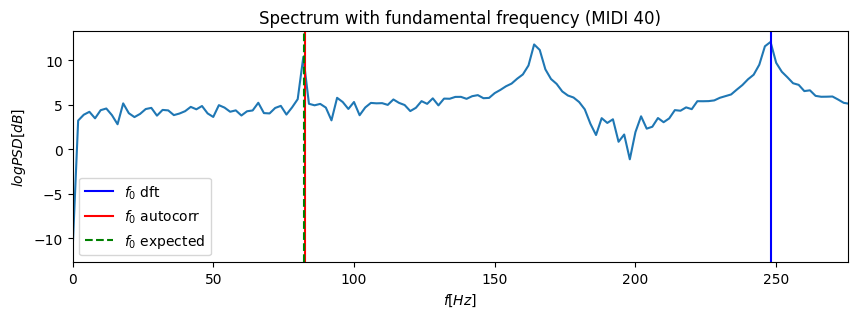

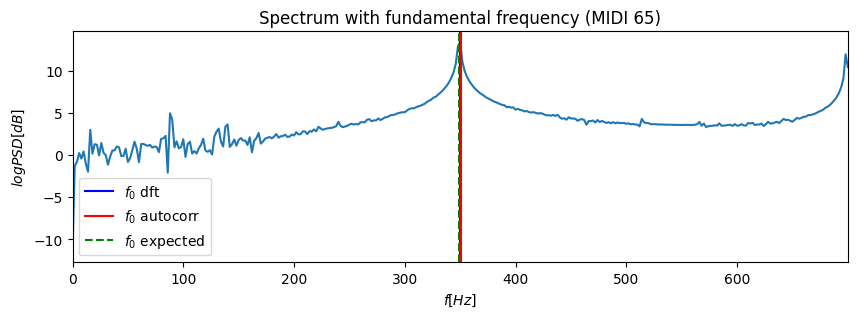

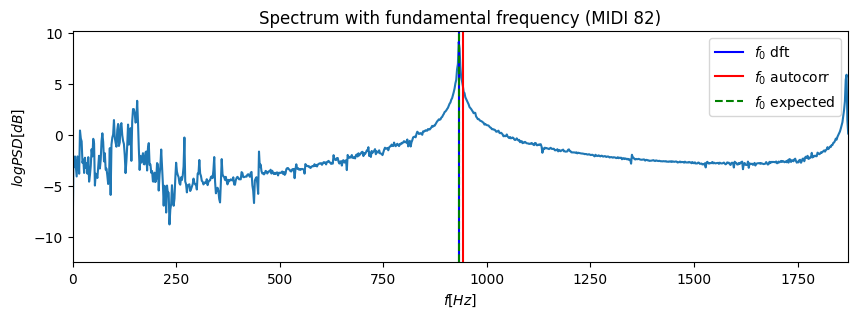

In [46]:
# 4.2 Fundamental frequency estimation (Určení základní frekvence)

# get fundamental frequency of MIDI tone with DFT and autocorrelation
midi_fmax_dft = np.zeros(MIDITO+1)
midi_fmax_ac = np.zeros(MIDITO+1)
for tone in tones:

    # dft
    X = np.fft.fft(xall[tone])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs                   # kall -> fnorm -> f

    # find max
    midi_fmax_dft[tone] = f[np.argmax(Xmag)]

    # autocorrelation
    Rk = np.correlate(xall[tone], xall[tone], mode='full') / N
    Rk = Rk[Rk.size//2:]  # take only positive part

    # filter
    threshold = np.max(Rk) * 0.9
    Rk_filtered = np.where(Rk > threshold, Rk, 0)

    # first max peak is always at 0
    first_max_idx = np.argmax(Rk_filtered)

    # second max peak is first from found peaks
    peaks, _ = ss.find_peaks(Rk_filtered)
    second_max_idx = peaks[0]

    period = second_max_idx - first_max_idx
    midi_fmax_ac[tone] = Fs / (period)

    # plt.figure(figsize=(10,3))
    # plt.title('Autokorelace (MIDI %d)' % tone)
    # plt.plot(Rk)
    # plt.plot(Rk_filtered, 'r--')
    # #plt.plot(peaks, Rk[peaks], "o")
    # plt.plot(first_max_idx, Rk[first_max_idx], 'ro')
    # plt.plot(second_max_idx, Rk[second_max_idx], 'go')
    # plt.ylabel('$R[k]$')
    # plt.xlabel('$k$')
    # plt.show()

    # plot my tones
    if tone in SELECTED_MIDI:
        
        spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

        # average of all frequencies
        freq_avg = np.mean([midi_fmax_dft[tone], midi_fmax_ac[tone], midi_fmax_orig[tone]])

        plt.figure(figsize=(10,3))
        plt.title('Spectrum with fundamental frequency (MIDI %d)' % tone)
        plt.plot(f, spect)
        plt.axvline(midi_fmax_dft[tone], color='blue', linestyle='-', label='$f_0$ dft')
        plt.axvline(midi_fmax_ac[tone], color='red', linestyle='-', label='$f_0$ autocorr')
        plt.axvline(midi_fmax_orig[tone], color='green', linestyle='--', label='$f_0$ expected')
        plt.legend()
        plt.xlim([0,2*freq_avg])
        plt.ylabel('$logPSD[dB]$')
        plt.xlabel('$f[Hz]$')
        plt.show()

Results of DFT and autocorrelation are shown in graph below, where the accuracy of both is visible. DFT has found the fundamental frequency of mostly lower tones multiplicated by 2 or 3. However the accuracy of the DFT for other tones was really close to real one. While autocorrelation has found the fundamental frequency of all tones with good accuracy except for tones above MIDI 80, where the fundamental frequency accuracy is in wider range of accuracy probably due to the fact that the signal is not as clear as for lower tones and piano could be not tuned perfectly.

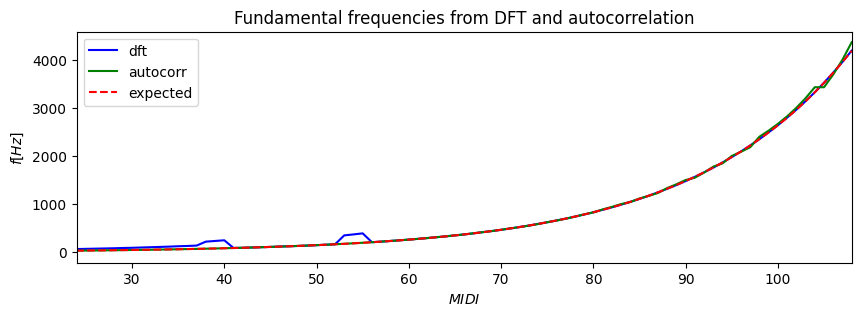

In [47]:
#print all calculated base frequencies
# for tone in tones:
#    print('MIDI %d:\t %.2f Hz (expected),  %.2f Hz (DFT),  %.2f Hz (autocorr)' % (tone, midi_fmax_orig[tone], midi_fmax_dft[tone], midi_fmax_ac[tone]))

plt.figure(figsize=(10,3))
plt.title('Fundamental frequencies from DFT and autocorrelation')
plt.xlim([MIDIFROM, MIDITO])
plt.plot(midi_fmax_dft, 'b')
plt.plot(midi_fmax_ac, 'g')
plt.plot(midi_fmax_orig, 'r--')
plt.legend(['dft', 'autocorr', 'expected'])
plt.ylabel('$f[Hz]$')
plt.xlabel('$MIDI$')
plt.show()

**4.3 Fundamental frequency approximation (Zpřesnění odhadu základní frekvence)**

I have selected results of DFT to approximate. At first I have applied hamming window for the original tone to reduce the influcence of bad cut of the signal. Then I have applied DFT to the windowed signal and selected the highest peak of the magnitude spectrum. 

Next I have made a DTFT on the discrete part of signal and selected frequency range for approximation $100c$. In applied DTFT I have selected the highest peak of the magnitude spectrum to find the fundamental frequency of my tone.

Lastly I have divided fundamental frequency for some tones, because found fundamental frequency was multipication of the real one. I have divided the fundamental frequency by 2 or 3, depending on the tone.

In [48]:
# 4.3 Fundamental frequency approximation (Zpřesnění odhadu základní frekvence)

# constants for aproximation
CENTS = 100                             # number of cents for aproximation
FREQ_RANGE = 2**(CENTS/1200)            # freq range for aproximation with cents
FREQ_POINTS = 200                       # number of points for aproximation

midi_fmax_dtft = np.zeros(MIDITO+1)
for tone in tones:

    # window
    Nfft = 2*Fs
    Flimit = N
    w = np.hamming(N)
    xw = xall[tone] * w
    xpad = np.pad(xw, (0, Nfft - N), 'constant', constant_values=0)

    # dft
    Xpad = np.fft.fft(xpad)
    klimited = np.arange(0,int(Flimit/Fs*Nfft))
    XpadMag = np.abs(Xpad[klimited])
    flimited = klimited / Nfft * Fs

    # get fundamental frequency from hamming windowed signal
    fmax = flimited[np.argmax(XpadMag)]

    # dynamic frequency range
    # FREQ_RANGE = 0.05 * fmax

    ffrom = fmax - FREQ_RANGE
    fto = fmax + FREQ_RANGE
    fsweep = np.linspace(ffrom, fto, FREQ_POINTS)

    # dtft 
    n = np.arange(0,N)
    A = np.zeros([FREQ_POINTS, N],dtype=complex)   
    for k in np.arange(0, FREQ_POINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs * n
    Xdtft = np.matmul(A,xall[tone].T)
    midi_fmax_dtft[tone] = fsweep[np.argmax(np.abs(Xdtft))]

    # NO HAMMING DTFT for comparison

    # # fundamental frequency from previous step dft
    # fmax = midi_fmax_dft[tone]; 
    # ffrom = fmax - FREQ_RANGE
    # fto = fmax + FREQ_RANGE
    # fsweep_noham = np.linspace(ffrom, fto, FREQ_POINTS)

    # # dtft 
    # n = np.arange(0,N)
    # A = np.zeros([FREQ_POINTS, N],dtype=complex)   
    # for k in np.arange(0, FREQ_POINTS):
    #     A[k,:] = np.exp(-1j * 2 * np.pi * fsweep_noham[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs * n
    # Xdtft_noham = np.matmul(A,xall[tone].T)
    # midi_fmax_dtft_noham = fsweep_noham[np.argmax(np.abs(Xdtft_noham))]

    # PLOT COMPARISON

    # plt.figure(figsize=(10,3)) 
    # plt.title('DTFT 100c (MIDI %d)' % tone)
    # plt.plot(fsweep,np.abs(Xdtft), 'b', label='hamming')
    # plt.plot(fsweep_noham,np.abs(Xdtft_noham), 'm', label='no hamming')
    # plt.axvline(midi_fmax_orig[tone], color='black', linestyle='--', label='expected')
    # plt.axvline(fmax, color='red', linestyle='--', label='dft (hamming)')
    # plt.axvline(midi_fmax_dtft[tone], color='blue', linestyle='--', label='dtft (hamming)')
    # plt.axvline(midi_fmax_ac[tone], color='green', linestyle='--', label='autocorr')
    # plt.axvline(midi_fmax_dft[tone], color='orange', linestyle='--', label='dft (no hamming)')
    # plt.axvline(midi_fmax_dtft_noham, color='magenta', linestyle='--', label='dtft (no hamming)')
    # plt.legend()
    # plt.gca().set_ylabel('$|X(e^{j\omega})|$')
    # plt.ylabel('$|X(e^{j\omega})|$')
    # plt.xlabel('$f[Hz]$')
    # plt.show()

    # CORRECTION OF DFT BASE FREQUENCY

    # some tones have missing base frequency in dft, so we divide found multiple by 2 or 3
    if tone < 38 or tone in [53, 54, 55] :
        midi_fmax_dtft[tone] = midi_fmax_dtft[tone] / 2
        fmax = fmax / 2
    elif tone < 41:
        midi_fmax_dtft[tone] = midi_fmax_dtft[tone] / 3
        fmax = fmax / 3

Results of approximation of fundamental frequency from DFT are shown in graph below. Accuracy of approximation is barely noticable. In comparison I have found that all differences from real fundamental frequency are under 2.5Hz. In tones below MIDI 80 the accuracy range is even under 0.1Hz. 

All the bigger differences from real fundamental frequency are in tones above MIDI 80. The reason could be that piano is not tuned perfectly in higher tones.

Result could be improved by incresing the frequency range of DTFT (e.g. $1200c$) or  changing frequency range to dynamic one, where the frequency range would be calculated from the inapproximated fundamental frequency of the tone.
With incresing the frequency range the number of frequency points for DTFT should be also increased to get better accuracy.

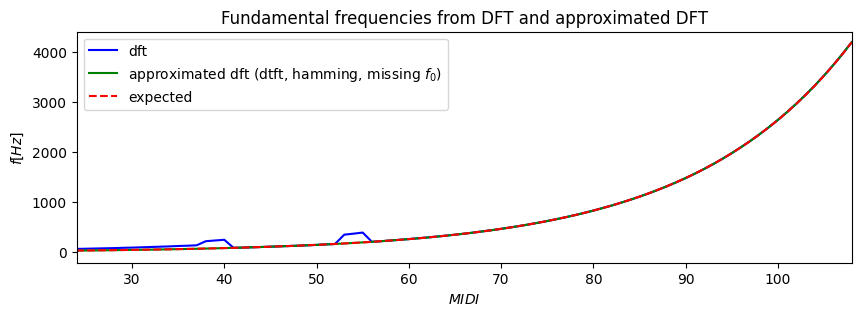

In [49]:
#print all calculated fundamental frequencies
# for tone in tones:
#     print('MIDI %d:\t %.2f Hz (expected),  %.2f Hz (DTFT),  %.2f Hz (diff)' % (tone, midi_fmax_orig[tone], midi_fmax_dtft[tone], abs(midi_fmax_orig[tone] - midi_fmax_dtft[tone])))

plt.figure(figsize=(10,3))
plt.title('Fundamental frequencies from DFT and approximated DFT')
plt.xlim([MIDIFROM, MIDITO])
plt.plot(midi_fmax_dft, 'b')
plt.plot(midi_fmax_dtft, 'g')
plt.plot(midi_fmax_orig, 'r--')
plt.legend(['dft', 'approximated dft (dtft, hamming, missing $f_0$)', 'expected'])
plt.ylabel('$f[Hz]$')
plt.xlabel('$MIDI$')
plt.show()

**4.4 Representation of the piano (Reprezentace klavíru)**

Result of previous fundamental frequency approximation was used to approximate all the multiplications of the fundamental frequency of the tone. I have used the same method as in previous section.

Accuracy of approximation for multiplications of higher tones is noticable in graph.
The accuracy could be improved as metioned in previous section. 

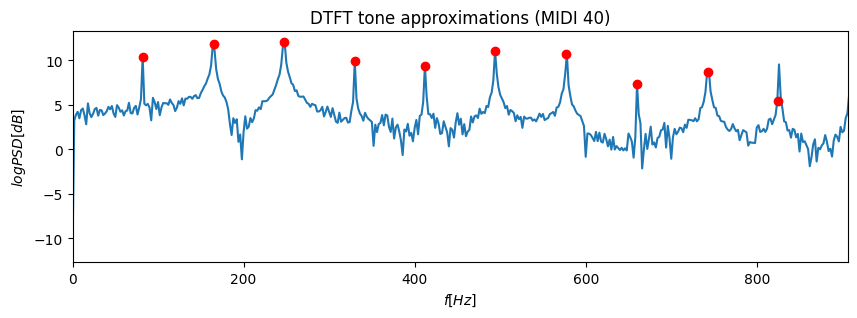

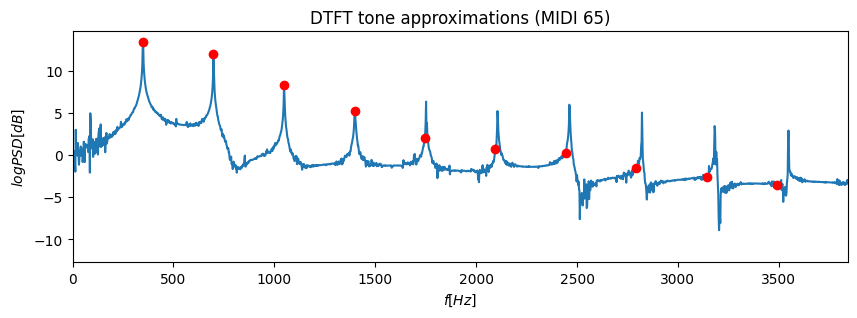

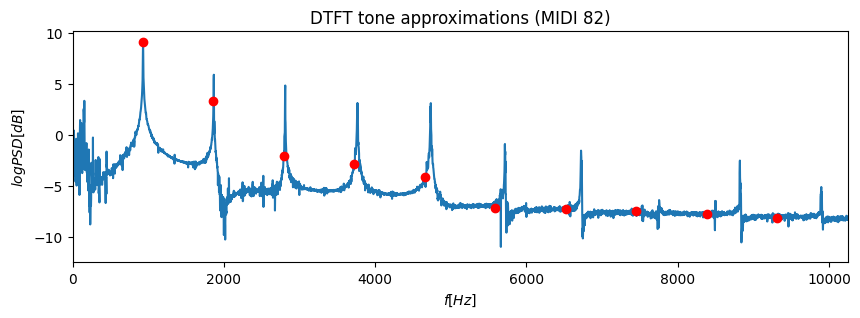

In [50]:
# 4.4 Representation of the piano (Reprezentace klavíru)

midi_dtft_freq = np.zeros((MIDITO+1, 11))
midi_dtft_mag = np.zeros((MIDITO+1, 11))
midi_dtft_mag_all = np.zeros((MIDITO+1, 11, FREQ_POINTS))
fsweep = np.zeros((MIDITO+1, 11, FREQ_POINTS))
for tone in tones:

    # dft
    X = np.fft.fft(xall[tone])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs                   # kall -> fnorm -> f

    for i in range(1, 11):

        # get base frequency from previous step (dtft)
        fmax = midi_fmax_dtft[tone] * i

        # dynamic frequency range
        # FREQ_RANGE = 0.05 * fmax

        ffrom = fmax - FREQ_RANGE
        fto = fmax + FREQ_RANGE
        fsweep[tone][i] = np.linspace(ffrom, fto, FREQ_POINTS)

        # dtft 
        n = np.arange(0,N)
        A = np.zeros([FREQ_POINTS, N],dtype=complex)   
        for k in np.arange(0, FREQ_POINTS):
            A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[tone][i][k] / Fs * n)     # norm. omega = 2 * pi * f / Fs * n 
        Xdtft = np.matmul(A,xall[tone].T)

        midi_dtft_mag_all[tone][i] = np.abs(Xdtft)
        midi_dtft_mag[tone][i] = np.max(np.abs(Xdtft))
        midi_dtft_freq[tone][i] = fsweep[tone][i][np.argmax(np.abs(Xdtft))]

    # plot my tones
    if tone in SELECTED_MIDI:

        spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

        # plot analysis
        plt.figure(figsize=(10,3))
        plt.title('DTFT tone approximations (MIDI %d)' % tone)
        plt.plot(f, spect)
        for i in range(1, 11):
            #plt.axvline(midi_dtft_freq[tone][i], color='red', linestyle='--')
            plt.plot(midi_dtft_freq[tone][i], spect[int(round(midi_dtft_freq[tone][i]/2))], 'ro')
            #plt.plot(fsweep[tone][i], np.log(1e-5+midi_dtft_mag_all[tone][i]**2), 'g')
        plt.xlim((0, 11* midi_fmax_dtft[tone]))
        plt.ylabel('$logPSD[dB]$')
        plt.xlabel('$f[Hz]$')
        plt.show()
    

All the other tasks were not done due to bad time distribution and lack of time in the end of semester.

However project showed me problems of signal analysis and how to solve them. I have learned how to use DFT and autocorrelation to find the fundamental frequency of signal. I have also learned how to use filter to find only the highest peaks of signal and how to approximate the results in signal analysis.